# Machine Learning and Prediction in Python

As noted in the Stata part of the lab, Python has several very powerful machine-learning libraries. In this part of the lab, we will use the `scikit-learn` library to perform a number of machine learning tasks.

`scikit-learn` is very well documented and has several examples you can use to learn how to use the library.

This notebook accompanies the Stata part of the lab. We'll work through a typical machine-learning workflow in Python.

Our goal is to produce a model that predicts the log sales price of a house based on some house characteristics. We will do this by comparing the performance LASSO and Random Forest. For an introduction to Random Forests, see [this link](https://www.ibm.com/topics/random-forest) and the SKLearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).


### 1. Load and prepare the data

We will again use the `kielmc` dataset. The dataset covers house sales, and the prediction task is to predict the log sales price based on some house characteristics: the number of rooms and bathrooms, the age and the area of the house, and the land area of the property where the house is located.

In [135]:
import numpy as np             
import pandas as pd             
import matplotlib.pyplot as plt 

# load and prepare the data
url = "http://fmwww.bc.edu/ec-p/data/wooldridge/kielmc.dta"
data = pd.read_stata(url)

# Display basic information about the dataset
data.info()

# View the first 5 rows of the data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      321 non-null    float32
 1   age       321 non-null    float32
 2   agesq     321 non-null    float32
 3   nbh       321 non-null    float32
 4   cbd       321 non-null    float32
 5   intst     321 non-null    float32
 6   lintst    321 non-null    float32
 7   price     321 non-null    float32
 8   rooms     321 non-null    float32
 9   area      321 non-null    float32
 10  land      321 non-null    float32
 11  baths     321 non-null    float32
 12  dist      321 non-null    float32
 13  ldist     321 non-null    float32
 14  wind      321 non-null    float32
 15  lprice    321 non-null    float32
 16  y81       321 non-null    float32
 17  larea     321 non-null    float32
 18  lland     321 non-null    float32
 19  y81ldist  321 non-null    float32
 20  lintstsq  321 non-null    float3

,year,age,agesq,nbh,cbd,intst,lintst,price,rooms,area,...,lprice,y81,larea,lland,y81ldist,lintstsq,nearinc,y81nrinc,rprice,lrprice
0,1978.0,48.0,2304.0,4.0,3000.0,1000.0,6.9078,60000.0,7.0,1660.0,...,11.00210,0.0,7.414573,8.429017,0.0,47.717701,1.0,0.0,60000.0,11.00210
1,1978.0,83.0,6889.0,4.0,4000.0,1000.0,6.9078,40000.0,6.0,2612.0,...,10.59663,0.0,7.867871,9.032409,0.0,47.717701,1.0,0.0,40000.0,10.59663
2,1978.0,58.0,3364.0,4.0,4000.0,1000.0,6.9078,34000.0,6.0,1144.0,...,10.43412,0.0,7.042286,8.517193,0.0,47.717701,1.0,0.0,34000.0,10.43412
3,1978.0,11.0,121.0,4.0,4000.0,1000.0,6.9078,63900.0,5.0,1136.0,...,11.06507,0.0,7.035269,9.210340,0.0,47.717701,1.0,0.0,63900.0,11.06507
4,1978.0,48.0,2304.0,4.0,4000.0,2000.0,7.6009,44000.0,5.0,1868.0,...,10.69195,0.0,7.532624,9.210340,0.0,57.773682,1.0,0.0,44000.0,10.69195


We have loaded the data. We can see that the dataset contains 321 observations and 25 variables. The data is all in float32 format.

Since all the columns have 321 non-null entries, we don't need to handle missing data.

Next we will select the variables we will use to predict `lprice` and store them in a variable called `X`. We will also store the outcome variable `lprice` in a variable called `y`.

In [136]:
# Select features and target variable
selected_features = ['year', 'age', 'rooms', 'area', 'land', 'baths', 'dist']
X = data[selected_features]
y = data['lprice']

# Display first 5 rows
X.head()

,year,age,rooms,area,land,baths,dist
0,1978.0,48.0,7.0,1660.0,4578.0,1.0,10700.0
1,1978.0,83.0,6.0,2612.0,8370.0,2.0,11000.0
2,1978.0,58.0,6.0,1144.0,5000.0,1.0,11500.0
3,1978.0,11.0,5.0,1136.0,10000.0,1.0,11900.0
4,1978.0,48.0,5.0,1868.0,10000.0,1.0,12100.0


Now, before we perform any machine learning, let's put aside $20\%$ of our data, which we will use later to evaluate the performance of the ML models. We will do this using the `train_test_split` function from `scikit-learn` which returns a random split of the data into training and test sets. The `random_state` argument ensures that we get the same split every time we run the code.

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Preprocessing

Preprocessing transforms the raw data into a better format for machine learning.

We will build a preprocessing pipeline that will standardise and then take all combinations of continuous variables up to the second degree, and create dummy variables for categorical variables (called one-hot encoding in machine-learning jargon).

Let’s first see the code and then explain it. 

In [138]:
# Import the preprocessing functions from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),                               # Standardise data
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Add polynomial and interactions
])

# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, ['age', 'area', 'land', 'dist', 'rooms']),
        ('cat', OneHotEncoder(), ['baths'])
    ])


Our preprocessor will handle the columns differently depending on whether they are numerical or categorical. 

The numerical columns ('age', 'area', 'land', 'dist', 'rooms') will go through the `numerical_pipeline`. In this pipeline, we first apply the `StandardScaler()`, which standardises the variables by removing the mean and scaling to unit variance. Then, we use `PolynomialFeatures()` to generate polynomial and interaction variables. 

For the categorical variable 'baths', we apply `OneHotEncoder()`. This converts the categorical variable into a dummy variable.



## Hyperparameter tuning

We will compare the performance of two different models. Firstly LASSO regression and secondly a random forest. We will use cross-validation to select the best tuning parameters for each model.

Now let's build our cross validation pipeline

In [139]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create pipelines for LASSO and Random Forest
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso())])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor())])

*Hyperparameter tuning* is an essential step in building machine-learning models. Hyperparameters are the parameters of the learning algorithm itself instead of the parameters derived from the learning process. They are the machine learning algorithm settings that we adjust before the actual training process begins. Fine-tuning the hyperparameters can significantly improve the performance of a model.

In our case, when we say we're tuning the 'alpha' for the Lasso regression, we're adjusting the strength of the penalty applied to the model. Lasso regression applies a penalty to the absolute size of the regression coefficients, helping to shrink less important variables' coefficients to zero, thereby performing variable selection. The 'alpha' is this penalty parameter, and finding the optimal 'alpha' can help us build a more accurate and efficient model.

For the random forest model, we're tuning 'max_depth', which determines the maximum depth of each decision tree in our random forest. A tree's depth is its number of levels, and the deeper the tree, the more complex and detailed our model becomes. However, if we set 'max_depth' too high, our model can become overfit, meaning it performs well on the training data but poorly on unseen data. By tuning 'max_depth', we seek a balance between model complexity and generality.

However, it's important to note that multiple hyperparameters are usually tuned in combination to find the most optimal set of settings. This process typically involves techniques such as grid search or randomised search, where various combinations of hyperparameters are tested, and the best combination is selected based on model performance.

Now, let’s define the tuning parameters for each model.

In [140]:
# Define parameter grids for LASSO and Random Forest
param_grid_lasso = {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_rf = {'regressor__max_depth': [None, 10, 20, 30]}

Now, we can use k-fold cross-validation to select the best tuning parameters for each model.

In [141]:
# Create GridSearchCV objects
grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search_lasso.fit(X, y)
grid_search_rf.fit(X, y)

# Retrieve the best parameters
best_params_lasso = grid_search_lasso.best_params_
best_params_rf = grid_search_rf.best_params_

print(f"Best parameters for LASSO: {best_params_lasso}")
print(f"Best parameters for Random Forest: {best_params_rf}")

Best parameters for LASSO: {'regressor__alpha': 0.01}
Best parameters for Random Forest: {'regressor__max_depth': None}


Let's break down this block of code:

We define `grid_search_lasso` and `grid_search_rf` as `GridSearchCV` objects. In these objects, we specify the pipeline (which includes the preprocessing steps and the actual regressor) we wish to optimise, the dictionary of hyperparameters (`param_grid_lasso` or `param_grid_rf`) with possible values we want to try, the number of folds for cross-validation (`cv=5`), and the scoring metric (`'neg_mean_squared_error'`).

We fit the `GridSearchCV` object to our data using the .fit() method. This operation will run a cross-validation process for each combination of hyperparameters we specified in `param_grid_lasso` or `param_grid_rf`. In this case, it's running the process for different values of 'alpha' for LASSO and 'max_depth' for Random Forest.

Once the fitting is done, we retrieve the best parameters found by `GridSearchCV` for each model using the `.best_params_attribute`. This gives us the hyperparameters that resulted in the highest performance (lowest mean squared error in this case), according to the cross-validation process.

Finally, we print these best parameters to see which values were optimal for each model.

### Model Evaluation

We'll now re-train the models with the best hyperparameters and evaluate their performance on the training and test sets. Specifically, we'll look at MSE to understand the models' predictive accuracy.

In [142]:
# Update the pipelines with the best hyperparameters
pipeline_lasso.set_params(regressor__alpha=best_params_lasso['regressor__alpha'])
pipeline_rf.set_params(regressor__max_depth=best_params_rf['regressor__max_depth'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'area', 'land',
                                                   'dist', 'rooms']),
                                                 ('cat', OneHotEncoder(),
                                                  ['baths'])])),
                ('regressor', RandomForestRegressor())])

In [143]:
# Train the models with best hyperparameters
pipeline_lasso.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['age', 'area', 'land',
                                                   'dist', 'rooms']),
                                                 ('cat', OneHotEncoder(),
                                                  ['baths'])])),
                ('regressor', RandomForestRegressor())])

Now that we have re-trained the models using the best parameters let’s make some predictions on our test data. Remember, the machine learning model has not encountered the test data yet, ensuring we can assess its predictive performance objectively. We'll make predictions using the test data and then evaluate the models based on these predictions, comparing calculated and real outcomes.



MSE on train set for LASSO: 0.06495934581850671
MSE on test set for LASSO: 0.08097191687877046
MSE on train set for Random Forest: 0.010571341001297807
MSE on test set for Random Forest: 0.07860422918342488


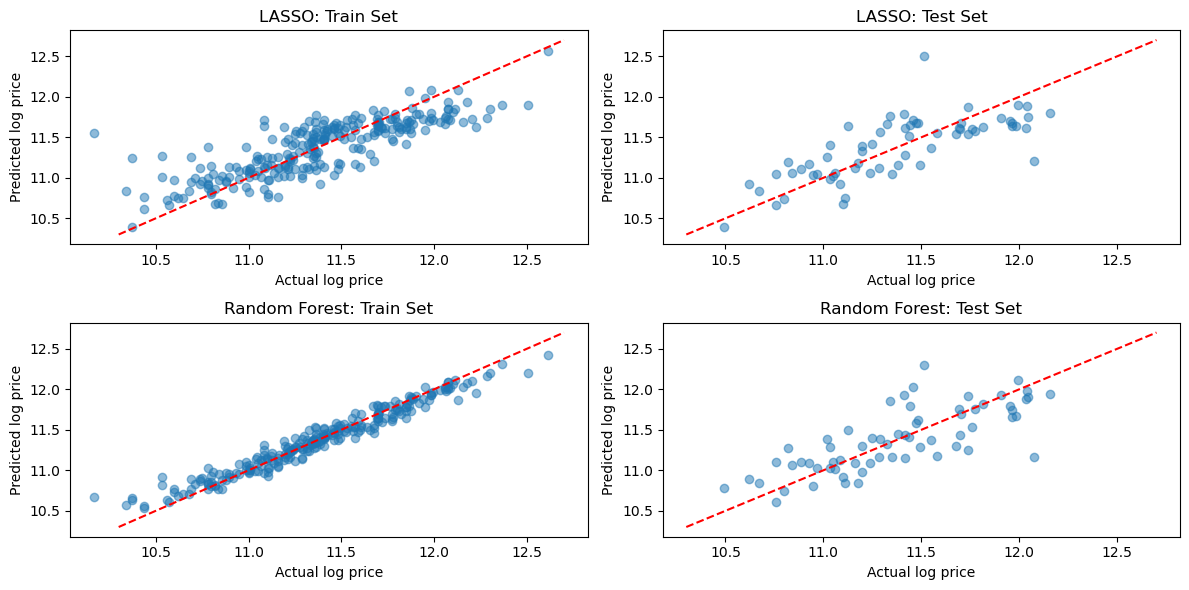

In [144]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Make predictions
y_pred_train_lasso = pipeline_lasso.predict(X_train)
y_pred_test_lasso = pipeline_lasso.predict(X_test)

y_pred_train_rf = pipeline_rf.predict(X_train)
y_pred_test_rf = pipeline_rf.predict(X_test)

# Evaluate the models
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_test_lasso = mean_squared_error(y_test, y_pred_test_lasso)

mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_test_rf = mean_squared_error(y_test, y_pred_test_rf)

print(f"MSE on train set for LASSO: {mse_train_lasso}")
print(f"MSE on test set for LASSO: {mse_test_lasso}")

print(f"MSE on train set for Random Forest: {mse_train_rf}")
print(f"MSE on test set for Random Forest: {mse_test_rf}")

# Plot the predictions
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].scatter(y_train, y_pred_train_lasso, alpha=0.5)
ax[0, 0].plot([10.3, 12.7], [10.3, 12.7], color='red', linestyle='--')# 45 degree line
ax[0, 0].set_title('LASSO: Train Set')
ax[0, 0].set_xlabel('Actual log price')
ax[0, 0].set_ylabel('Predicted log price')

ax[0, 1].scatter(y_test, y_pred_test_lasso, alpha=0.5)
ax[0, 1].plot([10.3, 12.7], [10.3, 12.7], color='red', linestyle='--')# 45 degree line
ax[0, 1].set_title('LASSO: Test Set')
ax[0, 1].set_xlabel('Actual log price')
ax[0, 1].set_ylabel('Predicted log price')

# Plot the predictions
ax[1, 0].scatter(y_train, y_pred_train_rf, alpha=0.5)
ax[1, 0].plot([10.3, 12.7], [10.3, 12.7], color='red', linestyle='--')# 45 degree line
ax[1, 0].set_title('Random Forest: Train Set')
ax[1, 0].set_xlabel('Actual log price')
ax[1, 0].set_ylabel('Predicted log price')

ax[1, 1].scatter(y_test, y_pred_test_rf, alpha=0.5)
ax[1, 1].plot([10.3, 12.7], [10.3, 12.7], color='red', linestyle='--')# 45 degree line
ax[1, 1].set_title('Random Forest: Test Set')
ax[1, 1].set_xlabel('Actual log price')
ax[1, 1].set_ylabel('Predicted log price')

plt.tight_layout()
plt.show()




The MSE on the training set for LASSO is 0.065, which signifies that, on average, the square difference between the observed outcomes and the predictions by the LASSO model is 0.065 for the training data. Likewise, the MSE on the test set for LASSO is 0.081, meaning that the average squared difference between observed and predicted values is slightly larger on the new, unseen data compared to the training set.

On the other hand, for the Random Forest model, the MSE on the training set is relatively low at 0.011, indicating that this model fits the training data very well. However, when applied to the test set, the MSE increases to 0.077. While this is still a reasonably good prediction, the increase in the error rate indicates that the Random Forest model may be overfitting on the training data.

The Random Forest model performs better (lower MSE) on the training and test sets than LASSO. However, it's important to remember that even though Random Forest has smaller errors, it seems to overfit the training data more than LASSO.

We can also see this in the plots, where the predictions on the training set lie closer to the 45-degree line for the random forest than the LASSO model. 

## Interpretability - Identifying Important Predictors
LASSO inherently performs feature selection by shrinking some coefficients to zero. Random Forest, on the other hand, provides feature importance scores. Feature importance gives us an understanding of which features (variables) contribute the most to the predictions made by the model. It helps in understanding the impact of certain variables on the model's performance and helps to identify the variables that are the most crucial for prediction.

Let's identify which variables are the most significant predictors for each model. Unfortunately, due to the structure and functionality of the pipeline, there is no straightforward method for obtaining the names of the variables associated with the feature importance scores or the coefficients. Don’t worry too much about the code; instead, think about interpreting the scores and coefficients.

In [148]:
# Get feature names for polynomial features
num_original_features_names = ['age', 'area', 'land', 'dist', 'rooms']
poly_features_names = preprocessor.named_transformers_['num']['poly'].get_feature_names_out(input_features=num_original_features_names)

# Get feature names for one-hot encoded features
cat_features_names = preprocessor.named_transformers_['cat'].get_feature_names_out(input_features=['baths'])

# Concatenate to get final feature names
final_feature_names = np.concatenate([poly_features_names, cat_features_names])

# Get feature importances from the fitted random forest model
feature_importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Map feature importances to feature names
feature_importance_mapping = dict(zip(final_feature_names, feature_importances))

# Sort by importance
sorted_features = sorted(feature_importance_mapping.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


area: 0.311301693230277
baths_3.0: 0.1283068012172661
age area: 0.09149102808592191
age: 0.07314421685166625
land: 0.044575829277048264
land dist: 0.03738836771475083
age dist: 0.030528867410898358
area land: 0.02663852107093684
area rooms: 0.02654574561900444
dist rooms: 0.025745930497756045
dist^2: 0.02468591210700778
area dist: 0.024658888741913916
age rooms: 0.023555949754622427
age land: 0.02327471831754664
land rooms: 0.022984165839139384
dist: 0.018035309528400458
land^2: 0.01692011603325518
area^2: 0.015322480670597768
age^2: 0.011147729215796853
rooms: 0.009533429719668609
baths_2.0: 0.007343937711097788
baths_1.0: 0.003379334776460916
rooms^2: 0.003169251638517605
baths_4.0: 0.0003217749704486031


In [146]:
# Get coefficients from the fitted random forest model
coefs = pipeline_lasso.named_steps['regressor'].coef_

# Map feature importances to feature names
coef_mapping = dict(zip(final_feature_names, coefs))

# Sort by absolute size
sorted_features = sorted(coef_mapping.items(), key=lambda x: np.abs(x[1]), reverse=True)

for feature, coefs in sorted_features:
    print(f"{feature}: {coefs}")


area: 0.18896330414591286
baths_3.0: 0.1429034073168659
age: -0.12029639718465568
age dist: 0.042412419432982594
land dist: -0.04235974863731979
rooms: 0.034091862933122254
age rooms: 0.018834569232854554
dist rooms: -0.014940312815113627
dist^2: -0.01310340992008904
area land: 0.011232553002221113
area rooms: 0.009885626656448635
land: 0.005731758004550082
age land: 0.003639715168539355
age area: -0.0035075783209376757
rooms^2: -0.0018649220513631158
land^2: 0.00016708232260003177
dist: -0.0
age^2: 0.0
area^2: 0.0
area dist: 0.0
land rooms: 0.0
baths_1.0: -0.0
baths_2.0: -0.0
baths_4.0: -0.0


# Exercise
Another commonly used machine learning model is Ridge regression. Try to implement a Ridge regression model and compare its performance to LASSO and Random Forest. You can find the documentation for Ridge regression [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

You will have to do the following:

1. Set up a ridge regression pipeline with the same preprocessing steps as the LASSO pipeline.
2. Set up a parameter grid for the ridge regression model. The parameter grid should include the alpha parameter with values `[0.001, 0.1, 1, 10, 100, 1000]`
3. Use the `GridSearchCV` function to find the best parameters for the ridge regression model.
4. Re-train the ridge regression model with the best parameters and evaluate its performance on the training and test sets.
5. Compare the performance of the ridge regression model to the LASSO and Random Forest models.

In [147]:
from sklearn.linear_model import Ridge

# Your code here